# What is Sentiment Analysis ?

- It is classiffication of the polarity of the text in a document, sentence or phrase
2. The Goal is to determine whether the expressed opinion in the text is positive or negative

# Why is Sentiment Analysis important ?

 - Microblogging has become popular communication tool 
 2. Opinion of the mass is important
 3. Political party may want to know whether people support their program or not.
 4. Before investing into a company, one can leverage the sentiment of the people for the company to find out where it stands.
 5. A company might want find out the reviews of its products 

# Using Twiter for Sentiment Analysis

 - Popular microblogging site
 2. Short Text Messages of 140 characters 
 3. 240+ million active users.
 4. 500 million tweets are generated everyday 
 5. Twitter audience varies from common man to celebrities.
 6. Users often discuss current affairs and share personal views on various subjects.
 7. Tweets are small in length and hence unambiguous 

# Objective

 - Given a message containing a marked instance of a word or a phrase, determine whether that instance is positive or  negative in that context.

# Obtaining the Data

In [1]:
#Importing the necessary packages to do data manipulation and Data Analysis
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.externals import joblib
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer,word_tokenize,sent_tokenize
from nltk.stem.wordnet import WordNetLemmatizer

In [2]:
import pandas as pd
import numpy as np
import csv
import nltk
import string
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import random

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.externals import joblib
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem.wordnet import WordNetLemmatizer

import pickle
import re
from collections import Counter
from string import punctuation
import tweepy
from tweepy import OAuthHandler
import json
from wordcloud import WordCloud

import plotly
import plotly.plotly as py
import plotly.graph_objs as go 
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
cf.go_offline()

# from IPython.display import IFrame
# # import folium
# from folium import plugins
# from folium.plugins import MarkerCluster, FastMarkerCluster, HeatMapWithTime

pd.set_option('display.max_colwidth', -1)
plt.style.use('seaborn-white')

C:\Users\amogh\Anaconda\lib\site-packages\plotly\graph_objs\_deprecations.py:558: DeprecationWarning:

plotly.graph_objs.YAxis is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.layout.YAxis
  - plotly.graph_objs.layout.scene.YAxis


C:\Users\amogh\Anaconda\lib\site-packages\plotly\graph_objs\_deprecations.py:531: DeprecationWarning:

plotly.graph_objs.XAxis is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.layout.XAxis
  - plotly.graph_objs.layout.scene.XAxis




In [3]:
#Reading the train data
df_train = pd.read_csv('twitter_train_set.csv', encoding = "ISO-8859-1")

Let us see the shape of the training and the test data

In [4]:
print(df_train.shape)

(99989, 3)


ALright so we have around 100k entries in the training data set 

In [5]:
df_train.head()

ItemID  Sentiment  \
0  1       0           
1  2       0           
2  3       1           
3  4       0           
4  5       0           

                                                                                                                          SentimentText  
0                       is so sad for my APL friend.............                                                                         
1                     I missed the New Moon trailer...                                                                                   
2                omg its already 7:30 :O                                                                                                 
3            .. Omgaga. Im sooo  im gunna CRy. I've been at this dentist since 11.. I was suposed 2 just get a crown put on (30mins)...  
4           i think mi bf is cheating on me!!!       T_T

- We can observe that the data is indeed from tweet messages posted on twitter.
- The labels and the text do not seem to be in any listed order. This can be a problem if data is not randomly distributed as it can introduce biases to a learning model. In any case, we are going to use the Scikit Learn library which has a function to split our training and testing data and shuffle the data at the same time.
- Shuffling data reduces variance and makes sure our model can generalize better on the data and do less overfitting. We want to make sure the train and test dataset are representative of the overall distribution of the data.
- To that note, we also want to check the label frequency distribution in the data which is done below.
- Another observation we can make is that the text contains varying formats. Some words contain mixed case letters which need to be normalized to their base word. e.g.: ‘CRy’ changed to ‘cry’.
- Leaving words with first letter capitalized can be experimented with as they may hold a different feature space like the name of a person or country etc.

Let us see how the distribution of the sentiment looks like in the training data 

In [6]:
df_train['Sentiment'].value_counts()

1    56457
0    43532
Name: Sentiment, dtype: int64

It looks like it is fairly distributed between positive and negative sentiments. 

Let us now see how many words does the positive and negative tweets have in them and see if we can distinguish between them

In [7]:
def len_word(tweet):
    return (len(tweet.split()))

In [8]:
df_train['word_count'] = df_train['SentimentText'].apply(len_word)

In [9]:
x= df_train[df_train['Sentiment']==0]['word_count']
y= df_train[df_train['Sentiment']==1]['word_count']

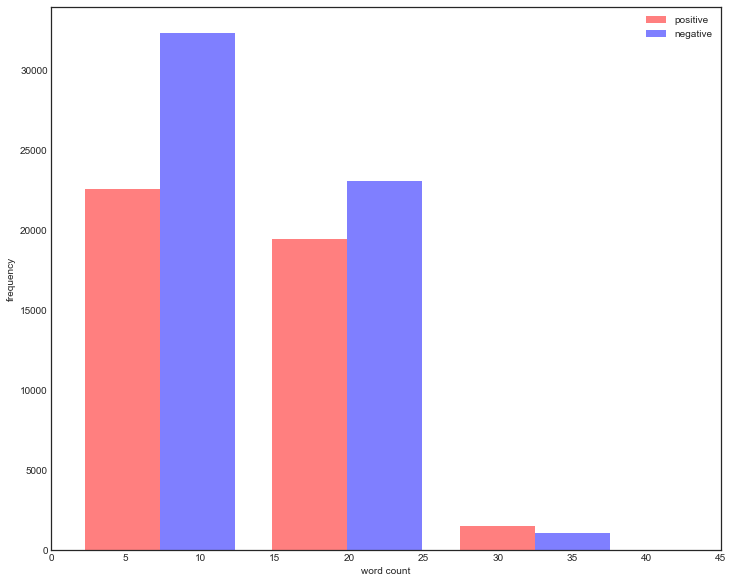

In [10]:
# plot word count distribution for both positive and negative sentiments
plt.figure(figsize=(12,10))
plt.xlim(0,45)
plt.xlabel('word count')
plt.ylabel('frequency')
g = plt.hist([x, y], color=['r','b'], alpha=0.5, label=['positive','negative'])
plt.legend(loc='upper right')

- we cannot really see any difference in the number of words between the positive and negative sentiment, and most of the words fall between 5-25 words. This is no wonder considering that twitter has a limit of how many characters one can use in a message. 280 characters is the limit at the time of this writing.
- it looks like 1–20 words covers more than 80% of all sentences which makes this dataset set a good training candidate.
- There are more positive sentences with 5 words or less than there are negative ones which does not seem like a big enough difference to cause any concern at the moment.

In [11]:
from collections import Counter
# get most common words in training dataset
all_words = []
for line in list(df_train['SentimentText']):
    words = line.split()
    for word in words:
        all_words.append(word.lower())
    
    
Counter(all_words).most_common(10)

[('i', 48880),
 ('the', 29629),
 ('to', 29177),
 ('you', 23456),
 ('a', 21908),
 ('and', 15826),
 ('it', 14154),
 ('my', 13598),
 ('for', 12378),
 ('is', 11618)]

- Perhaps to no surprise we encounter words like i, and and is as they are very highly used in human expressions. These kind of words usually appear equally in both negative and positive oriented expressions and as such they bring very little information that can be incorporated in the model so we will have to get rid of them down the road.
- In the text preprocessing steps later on we will learn how to deal with these common words that don’t add much to the feature space.
- Below is a code to output a graph showing the frequency of the first 25 words.

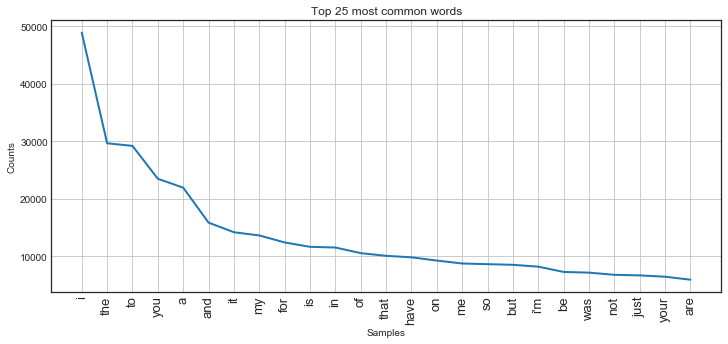

In [12]:
# plot word frequency distribution of first few words
plt.figure(figsize=(12,5))
plt.title('Top 25 most common words')
plt.xticks(fontsize=13, rotation=90)
fd = nltk.FreqDist(all_words)
fd.plot(25,cumulative=False)

In [13]:
#Fd has all the list of words along with the frequency of appearance in the context

In [14]:
#Say I want to see how many times a word "good" , "bad" appears 
print(fd["good"])
print(fd["bad"])

4918
1152


Good appears 4918 times and bad appears 1152 times in the training data that we have

In [ ]:
classifier = nltk.NaiveBayesClassifier.train(train_set)

In [ ]:
print(" Naive bayes Accuracy : ", (nltk.classify.accuracy(classifier, test_set)))

In [ ]:
import pickle
save_classifier = open("naivebayes.pickle","wb")
pickle.dump(classifier,save_classifier)
save_classifier.close()

In [ ]:
classifier_f = open("naivebayes.pickle","rb")
classifier = pickle.load(classifier_f)
classifier_f.close()

In [ ]:
nltk.classify.accuracy(classifier,test_set)

In [49]:
from nltk.classify.scikitlearn import SklearnClassifier

In [48]:
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import  SVC, LinearSVC, NuSVC

In [ ]:
MNB_classifier =  SklearnClassifier(MultinomialNB())
MNB_classifier.train (train_set)

In [ ]:
print("MNB_classifier Accuracy : ", (nltk.classify.accuracy(MNB_classifier, test_set)))

In [ ]:
Bernouli_classifier =  SklearnClassifier(BernoulliNB())
Bernouli_classifier.train (train_set)
print("Bernouli_classifier Accuracy : ", (nltk.classify.accuracy(Bernouli_classifier, test_set)))

In [ ]:
GaussianNB_classifier =  SklearnClassifier(GaussianNB())
GaussianNB_classifier.train (train_set)
print("GaussianNB Accuracy : ", (nltk.classify.accuracy(GaussianNB_classifier, test_set)))

In [ ]:
LogisticRegression_classifier =  SklearnClassifier(LogisticRegression())
LogisticRegression_classifier.train (train_set)
print("LogisticRegression Accuracy : ", (nltk.classify.accuracy(LogisticRegression_classifier, test_set)))

In [ ]:
SGDClassifier_classifier =  SklearnClassifier(SGDClassifier())
SGDClassifier_classifier.train (train_set)
print("SGDClassifier Accuracy : ", (nltk.classify.accuracy(SGDClassifier_classifier, test_set)))

In [ ]:
SVC_classifier =  SklearnClassifier(SVC())
SVC_classifier.train (train_set)
print("SVC Accuracy : ", (nltk.classify.accuracy(SVC_classifier, test_set)))

In [ ]:
LinearSVC_classifier =  SklearnClassifier(LinearSVC())
LinearSVC_classifier.train (train_set)
print("LinearSVC Accuracy : ", (nltk.classify.accuracy(LinearSVC_classifier, test_set)))

In [ ]:
NuSVC_classifier =  SklearnClassifier(NuSVC())
NuSVC_classifier.train (train_set)
print("NuSVC Accuracy : ", (nltk.classify.accuracy(NuSVC_classifier, test_set)))

In [ ]:
import tweepy
import csv

# Reading twitter Raw data

In [15]:
#!/usr/bin/python
# -*- coding: utf-8 -*-

import json

# create a dictionary to store your twitter credentials

twitter_cred = dict()

# Enter your own consumer_key, consumer_secret, access_key and access_secret
# Replacing the stars ("********")


# Save the information to a json so that it can be reused in code without exposing
# the secret info to public

with open('twitter_credentials.json', 'w') as secret_info:
    json.dump(twitter_cred, secret_info, indent=4, sort_keys=True)

In [21]:
#!/usr/bin/python
# -*- coding: utf-8 -*-

import tweepy
import csv
import json

# Twitter API credentials

with open('twitter_credentials.json') as cred_data:
    info = json.load(cred_data)
    
    consumer_key="KB9zbXLx2sqahEM3U68KV35Yy"
    consumer_secret="7Ls3bYOIikUkmf54ZFAFP6yugnWGyeyX5dJQmp4XaGNqQ6cZTp"
    access_key="623888556-GxxrfyUXvqmhVMRY2nU1mSOXXkYTMRYEPhqgX3Cd"
    access_secret="mm0Nws39fgXJ3jRz4b3XzIrnWvviAb0k2PS3QOGdXxBwd"

# Create the api endpoint

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
api = tweepy.API(auth,wait_on_rate_limit=True,wait_on_rate_limit_notify=True)

# Mention the maximum number of tweets that you want to be extracted.

maximum_number_of_tweets_to_be_extracted = \
    int(input('Enter the number of tweets that you want to extract- '))

# Mention the hashtag that you want to look out for


# use csv Writer

hashtag = input('Enter the hashtag you want to scrape- ')
csvFile = open(hashtag + '_twitter.csv', 'w', encoding='utf-8')
csvWriter = csv.writer(csvFile)
# tweet_num = 0
# for tweet in tweepy.Cursor(api.search, q='#' + hashtag '-RT' ,
#                            rpp=100 , lang="en").items(maximum_number_of_tweets_to_be_extracted):
#     if(tweet.lang=='en'):
#             # not entirely necessary but you can inspect what is being written to file
#             # write data to csv
#             csvWriter.writerow([tweet.created_at,
#                                 tweet.user.location,
#                                 tweet.user.followers_count,
#                                 tweet.user.friends_count,
#                                 tweet.text])
#             tweet_num += 1
            
# csvFile.close()
            
# print ('Extracted ' + str(maximum_number_of_tweets_to_be_extracted) \
#     + ' tweets with hashtag #' + hashtag)


tweet_num = 0
for tweet in tweepy.Cursor(api.search,q= hashtag+ ' -RT',count=10000000,lang="en").items(maximum_number_of_tweets_to_be_extracted):
    if tweet.place is not None:
        try:
            # not entirely necessary but you can inspect what is being written to file
            print ('tweet number: {}'.format(tweet_num), tweet.text, tweet.place.full_name)
            # write data to csv
            csvWriter.writerow([tweet.created_at,
                                tweet.user.location,
                                tweet.user.followers_count,
                                tweet.user.friends_count,
                                tweet.text,
                                tweet.place.bounding_box.coordinates,
                                tweet.place.full_name,
                                tweet.place.country,
                                tweet.place.country_code,
                                tweet.place.place_type])
            tweet_num += 1
            
        except Exception:
            pass


csvFile.close()

Enter the number of tweets that you want to extract- 10000
Enter the hashtag you want to scrape- Twitter
tweet number: 0 rip walmart lizard https://t.co/ooGgP1iSwo Walmart
tweet number: 1 @BigPapiYogii @sincerelydem Ok now you are dragging it johangel https://t.co/H5gkFYYlg6 Manhattan, NY
tweet number: 2 You not gon do shit https://t.co/MfV2AJkmB4 Oakland, CA
tweet number: 3 Benny’s vlogs stay having me omn 😂😂😂 @BennySoliven https://t.co/thUB5gw8Nl San Pablo, CA
tweet number: 4 Treason he should be charged with. What pink coloured glasses are you wearing. https://t.co/tQ2x6iVjOv Fingal, Ireland
tweet number: 5 Christmas Eve des 24 at 6pm@at dome of Harvest https://t.co/jsJmiI1FMC Jati Uwung, Indonesia
tweet number: 6 @PressSec  Amazed you haven't denied this yet. C'mon Sarah. Sob, you probably have only a couple of thousand lies l… https://t.co/TtaO8L8ECr Los Angeles, CA
tweet number: 7 PLEASE PLEASE PLEASE KNOW THAT I AM THAT FRIEND THAT WILL SCOOP YOU IF IM AVAILABLE. IDC WHERE YOU’R

tweet number: 72 But I am in control of my money why must they just take it https://t.co/EzG7YDzBwf Randburg, South Africa
tweet number: 73 Interesting thread... https://t.co/HdjOmVgaUn Malawi
tweet number: 74 Blacks are a mood everywhere in the world 😂😂✌🏾 https://t.co/EuPc1Ui1if Polokwane, South Africa
tweet number: 75 Cam is a budding star for both the volleyball and basketball teams over there. You can feel it. #nebpreps https://t.co/VU2aZ10yLA Fairbury, NE
tweet number: 76 Thigh
Wing
Breast
Leg 🤷🏽‍♂️🤷🏽‍♂️🤷🏽‍♂️ https://t.co/UnjTUTKeG8 Detroit, MI
tweet number: 77 I’m going to miss working here so much!! https://t.co/lNGbnZXGtv Florida, USA
tweet number: 78 Soo you’re telling me eating meat helps you be more efficient and saves you time for other activities? WOW thank yo… https://t.co/RnbgdPnDh1 East Foothills, CA
tweet number: 79 fool https://t.co/NJcbDkVOwj Catonsville, MD
tweet number: 80 #Vegan #ChampsDiner #NYC WOAH🤩Seitan Asada Fries for the win https://t.co/2PQTuq5kL2 Manhatta

tweet number: 147 Sree never cheated in any task and Kv's words were clear.'Puri duniya ko pata hai ki tu cheater hai'..if he meant i… https://t.co/gET63rMvXT Trivandrum, India
tweet number: 148 Argh! https://t.co/e7ZSvp27yh Marina del Rey, CA
tweet number: 149 Congress gave Adarsh scam, we are building real houses: PM Modi
https://t.co/etddo9RBpT

via NaMo App https://t.co/zzWSuni0KS Guntur, India
tweet number: 150 Today uBaba will #fillupBZ ...I will be there.🙌🙏 https://t.co/0XYy6dtJmC Siyanda, South Africa
tweet number: 151 Shriram properties is coming now to offer smart homes in Shriram Dil Chahta Hai township located at Electronic City… https://t.co/xDlUfn5Ahw Bengaluru, India
tweet number: 152 The villain. https://t.co/b3E6Ud1lRj Beltsville, MD
tweet number: 153 @RosaYaamileth Every green light we hit! https://t.co/pChpruaItx Houston, TX
tweet number: 154 Columbia "Dark and Stormy" Perkins https://t.co/aK5i3cZ8vU Halifax, Nova Scotia
tweet number: 155 @Electrahhh "Ya'll want to 3

tweet number: 223 I just... can I.... wow. 2018 finally gave me a break. https://t.co/yLR9IN3CEM Haslet, TX
tweet number: 224 Latest. Always. https://t.co/RmvK01mlTu Los Angeles, CA
tweet number: 225 Whoever is recording has me dead 💀 https://t.co/sSxRaOYXdb Texas, USA
tweet number: 226 You know me more than I know myself 😭💔 https://t.co/bjhW1Ec6YB Dover, OH
tweet number: 227 LMFAOOOOO WHEN DRAKES PART COMES UP OMG I can’t 😂😂😂😂😂 https://t.co/CuhWbgIP1u Tamiami, FL
tweet number: 228 I have been laughing all day because of this dumb image: https://t.co/S3kE2uPmWt Norwalk, CA
tweet number: 229 Haha..I don't think so..I believe in live and let live and if tomorrow BJP or Congress do good work.. I will not he… https://t.co/O6Iwc3GXnk Mumbai, India
tweet number: 230 Leg please 😭 https://t.co/4ggKud2cxq Daraga, Bicol Region
tweet number: 231 This is how solar microgeneration dies in the UK. https://t.co/QKEQ4HC4rc Burton upon Trent, England
tweet number: 232 Omg I need those so I can keep my 

tweet number: 299 Spaghetti casserole with ground turkey, cheese, thick spaghetti noodles, with diced tomatoes and tomato sauce.… https://t.co/RuuY5HxOpY Sunrise Manor, NV
tweet number: 300 He so fine 😩 https://t.co/rhDOKU74e6 Florida, USA
tweet number: 301 I bought a house and adopted two rescues. 🐕 🐕 🏡 https://t.co/IP4Gb3oT67 Sacramento, CA
tweet number: 302 "If you wanna entertain the world. Let’s do it, you will make happy someone: 📺 @Viacom @Whosay @MTV #Entertainment… https://t.co/Dn7wK8RMgZ Richmond, British Columbia
tweet number: 303 May perfect timing! 💕 https://t.co/YTJr0mvGbT Al Rayyan, Qatar
tweet number: 304 #WeAreAllLiam

I'm not laughing 😂 😂 😂 @LiamPayne https://t.co/3K7Rk4s9w0 Sri Lanka
tweet number: 305 Send Account Details 🤷‍♀️ https://t.co/Jxzd6zONVx Lagos, Nigeria
tweet number: 306 LA it has been two years. https://t.co/5n4UpCLiRn California, USA
tweet number: 307 This dude goes so hard. It’s hard not to respect the game. https://t.co/Qh3TbFAoFL The Goat
tweet numbe

tweet number: 380 Are you sure he’s 32? 😂 https://t.co/fe2iwym78B Lagos, Nigeria
tweet number: 381 Got sent this from #Buckinghamshire #NHS promoting  more physical activity in clinical, hospital  and patient envir… https://t.co/Csjee5yQmg Doncaster, England
tweet number: 382 @paulasmith45671 Seems like I've been following you a long time now. You come across as being sensitive so I've tri… https://t.co/tXtI1j0luD Georgia, USA
tweet number: 383 Best rapper alive 💯 https://t.co/lLh839i3vi Charlotte, NC
tweet number: 384 You can tell because of the gingerbread balls https://t.co/hWM154SKfM Seattle, WA
tweet number: 385 Dare I say..... not terrible? 🙊 https://t.co/p8eDzPnCgi Atlanta, GA
tweet number: 386 Oops!  Isaiah Dunn scores 20... https://t.co/AzBbGePwCI Pacific, WA
tweet number: 387 12.Javier Colon 

- like I and @DereknMarkFans said Dia should’ve won https://t.co/0TIAvCkHrD Kansas, USA
tweet number: 388 shane flanagan never watched the wire.
#noburners https://t.co/bi1zyux0wh Canbe

tweet number: 454 i love how they don’t even bother using his name lol https://t.co/3li9HTonk7 Pittsburgh, PA
tweet number: 455 I need this type of support 🤣😂😂😂😂🤣🤣🤣 https://t.co/GulQoMY02A Baltimore, MD
tweet number: 456 @LBVmagazine your continued support is invaluable #GrowingLancashire #businessgrowth #Lancashire @LBVPublisher you’… https://t.co/KwBluDZ2eX Preston, England
tweet number: 457 @bitwitkyle @PropertyBrother Time for renovation videos!!! https://t.co/eSD1YyIOea Ogdensburg, NY
tweet number: 458 🙋🏼‍♀️🍷 #Wining instead of #wrapping 🎁 https://t.co/K6EaZP47XI Rio Rancho, NM
tweet number: 459 @LAClippers can I get a 10-day contract?? I’m trying to see something real quick https://t.co/ZesgRJaJp0 Los Angeles, CA
tweet number: 460 can't wait ! https://t.co/SWZbiNaE2G Margaasih, Indonesia
tweet number: 461 Wait a minute she directed the Preacher's Wife? 

I knew I loved her

#RIPPennyMarshall 
Btw more than an actress,… https://t.co/TENjOgwy3U Nashville, TN
tweet number: 462 @TheL

tweet number: 527 Right. A nigga didn’t wake up until 3 https://t.co/TOszLYHOmS Fort Valley, GA
tweet number: 528 Girls with glasses are better 🤷🏾‍♂️ touch your soul different! https://t.co/0klUotZjXf Mississippi, USA
tweet number: 529 That. Block. Tho. 👀👀 https://t.co/PY2PU6fuV2 Ashburn, VA
tweet number: 530 The day she announced her pregnancy at Eugenie's wedding (and teased the press with her outfit), I was over this wo… https://t.co/Jm5keJGK3l Washington, DC
tweet number: 531 Replay Today: Dec. 18, 1941 (Hong Kong, China)
Normally a crowded Hong Kong street is shown while less than a mile… https://t.co/cVdnR85c1K Hong Kong
tweet number: 532 The 🇿🇦ZAR opened trading at R14.30/$🇺🇸, R16.28/€🇪🇺 and R18.10/£🇬🇧 this morning.
Are you looking to internationalize… https://t.co/6XaQrVVqhT Johannesburg, South Africa
tweet number: 533 I’m goin to Epcot with @timhays22 https://t.co/q6RiL5zglr Lubbock, TX
tweet number: 534 In malaysia, heavy traffic in all medium. https://t.co/z8y1Ieb8KL Petalin

tweet number: 595 🤧💜 thankss ! https://t.co/fOs0xh1FN2 Memphis, TN
tweet number: 596 my suite mate really did it to us https://t.co/EAVpsddo5k Gilbert, AZ
tweet number: 597 @GovLeeKinyanjui @susankihika we have one of the most promising counties in the country, it has so many unique qual… https://t.co/201lJclBbs Nairobi, Kenya
tweet number: 598 My goodness, she resembles the crypt keeper. 😳 https://t.co/9Qz8CUds1P Manteno, IL
tweet number: 599 | IT WAS LIT | 
#goindo24 #goindo24production #photography #photos #photographyenthusiast #sony #sonya6300… https://t.co/avm2ONCl1E Lembongan Island
tweet number: 600 do i get my phone privileges back mom ☹️ https://t.co/Ql8m88aK59 Irving, TX
tweet number: 601 I said the same thing https://t.co/YM1QiJ36lj San Diego, CA
tweet number: 602 “To realize the full potential of #AI, we need tools that make it easier for today’s #datascience teams to develop… https://t.co/2iRQP0JqRf Amstelveen, Nederland
tweet number: 603 @ItsJeffreyBrah. 
Kevin is. In a 

In [28]:
# create column names
col_names=['date','user_loc','followers','friends','message']

# read csv
df_twtr = pd.read_csv('Amazon_twitter_data.csv', names=col_names)
df_twtr['message'].drop_duplicates(inplace=True)

# # check head
# df_twtr.head(10)

In [ ]:

# twitter api credentials - you need these to gain access to API
consumer_key="KB9zbXLx2sqahEM3U68KV35Yy"
consumer_secret="7Ls3bYOIikUkmf54ZFAFP6yugnWGyeyX5dJQmp4XaGNqQ6cZTp"
access_token="623888556-GxxrfyUXvqmhVMRY2nU1mSOXXkYTMRYEPhqgX3Cd"
access_token_secret="mm0Nws39fgXJ3jRz4b3XzIrnWvviAb0k2PS3QOGdXxBwd"


# instantiate the api
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth,wait_on_rate_limit=True,wait_on_rate_limit_notify=True)

In [ ]:

# string to search on twitter
query = 'Tesla'

# open/create a csv file to append data
csvFile = open(query + '_data2.csv', 'w', encoding='utf-8')

# use csv Writer
csvWriter = csv.writer(csvFile)

# get data from twitter
tweet_num = 0
for tweet in tweepy.Cursor(api.search,q=query+ ' -RT',count=10000000,lang="en").items(10):
    if tweet.place is not None:
        try:
            # not entirely necessary but you can inspect what is being written to file
            print ('tweet number: {}'.format(tweet_num), tweet.text, tweet.place.full_name)
            # write data to csv
            csvWriter.writerow([tweet.created_at,
                                tweet.user.location,
                                tweet.user.followers_count,
                                tweet.user.friends_count,
                                tweet.text,
                                tweet.place.bounding_box.coordinates,
                                tweet.place.full_name,
                                tweet.place.country,
                                tweet.place.country_code,
                                tweet.place.place_type])
            tweet_num += 1
            
        except Exception:
            pass


Pre-processing 1:
- Clean tweet text by removing links, special characters
- This step is one that we could spend a lot of time on but the goal is always to find the best balance
- The bulk of the work in NLP is done on feature engineering and this is one of the processes that could alter the features you end up with.
- I created a funtion to do bulk formatting / clean up for every tweet in the dataset. The function is commented to show what every line is doing

In [29]:

# helper function to clean tweets
def processTweet(tweet):
    # Remove HTML special entities (e.g. &amp;)
    tweet = re.sub(r'\&\w*;', '', tweet)
    #Convert @username to AT_USER
    tweet = re.sub('@[^\s]+','',tweet)
    # Remove tickers
    tweet = re.sub(r'\$\w*', '', tweet)
    # To lowercase
    tweet = tweet.lower()
    # Remove hyperlinks
    tweet = re.sub(r'https?:\/\/.*\/\w*', '', tweet)
    # Remove hashtags
    tweet = re.sub(r'#\w*', '', tweet)
    # Remove Punctuation and split 's, 't, 've with a space for filter
    tweet = re.sub(r'[' + punctuation.replace('@', '') + ']+', ' ', tweet)
    # Remove words with 2 or fewer letters
    tweet = re.sub(r'\b\w{1,2}\b', '', tweet)
    # Remove whitespace (including new line characters)
    tweet = re.sub(r'\s\s+', ' ', tweet)
    # Remove single space remaining at the front of the tweet.
    tweet = tweet.lstrip(' ') 
    # Remove characters beyond Basic Multilingual Plane (BMP) of Unicode:
    tweet = ''.join(c for c in tweet if c <= '\uFFFF') 
    return tweet
# ______________________________________________________________

# clean dataframe's text column
df_twtr['message'] = df_twtr['message'].apply(processTweet)
# preview some cleaned tweets
df_twtr['message']

0       come over page there waiting for you…                                                                             
1       had lot showrooming today people taking pictures books and buying them from the store and eve…                    
2       NaN                                                                                                               
3       NaN                                                                                                               
4       NaN                                                                                                               
5       check out today deals click here                                                                                  
6       NaN                                                                                                               
7       for sale domain …                                                                                                 
8       NaN     

In [30]:
df_twtr['message'].drop_duplicates(inplace= True)

In [31]:
df_twtr.dropna(inplace=True)
df_twtr

date                       user_loc  followers  friends  \
0     2018-12-16 15:32:31  Ohio                           70316      21765     
1     2018-12-16 15:32:24  Silicon Valley, CA             677        1577      
5     2018-12-16 15:32:01  Flint, Michigan                2258       4992      
7     2018-12-16 15:31:54  Indore, India                  581        16        
9     2018-12-16 15:31:30  United States                  11798      1874      
10    2018-12-16 15:31:26  Worldwide                      51768      48021     
12    2018-12-16 15:31:20  Here There and Everywhere      5757       4410      
16    2018-12-16 15:30:57  United States                  92         784       
21    2018-12-16 15:30:27  Everyone has to be somewhere   15262      13997     
22    2018-12-16 15:30:26  Jamaica Plain, Massachussets   34         608       
24    2018-12-16 15:30:19  Worldwide                      51768      48021     
25    2018-12-16 15:30:18  Illinois, USA                  85         119       
28    2018-12-16 15:30:15  Gibraltar                      35         117       
29    2018-12-16 15:30:10  Florida, USA                   7337       6779      
32    2018-12-16 15:30:04  Platform 9 3/4                 1418       1057      
34    2018-12-16 15:30:02  New York City                  5693       3211      
35    2018-12-16 15:30:00  Montreal, Canada               2339       2483      
36    2018-12-16 15:29:53  United States                  862        1417      
38    2018-12-16 15:29:43  Greater Toronto                12699      11736     
39    2018-12-16 15:29:34  Bakersfield, CA                163        77        
41    2018-12-16 15:29:29  Worldwide                      51768      48021     
42    2018-12-16 15:29:22  Kolkata, India                 1384       1179      
43    2018-12-16 15:29:10  United States                  1778       3225      
45    2018-12-16 15:29:01  Haunting of Hill House         8          175       
46    2018-12-16 15:29:00  Lafayette, IN                  130        1816      
47    2018-12-16 15:28:56  Seattle-ish                    862        706       
48    2018-12-16 15:28:55  In DC's world                  1957       2965      
50    2018-12-16 15:28:33  Ontario, Canada                3530       3477      
51    2018-12-16 15:28:25  United States                  92         784       
52    2018-12-16 15:28:20  Jamaica Plain, Massachussets   34         608       
...                   ...                           ...   ..         ...       
6380  2018-12-16 03:21:17  India                          11971      6         
6382  2018-12-16 03:20:59  Texas                          312        269       
6383  2018-12-16 03:20:57  United States                  3328       3328      
6388  2018-12-16 03:20:01  Worldwide                      208217     144616    
6389  2018-12-16 03:20:01  Worldwide                      122229     110501    
6390  2018-12-16 03:19:59  India                          11971      6         
6392  2018-12-16 03:19:50  New Mexico                     2329       2253      
6394  2018-12-16 03:19:47  Semona                         261        104       
6397  2018-12-16 03:19:40  دبي, الامارات العربية المتحدة  3493       155       
6398  2018-12-16 03:19:36  New York, USA                  1364       1879      
6403  2018-12-16 03:19:01  Wisconsin, USA                 6533       50        
6405  2018-12-16 03:17:40  Arkansas, USA                  296        472       
6406  2018-12-16 03:17:38  North Branch, MI               2767       3025      
6412  2018-12-16 03:16:31  Toronto, Hamilton, KW Ontario  21754      19270     
6413  2018-12-16 03:16:19  Global                         25511      7938      
6414  2018-12-16 03:15:47  Seattle                        220        251       
6416  2018-12-16 03:15:23  La-weezy-anners                130        334       
6419  2018-12-16 03:15:04  Darbhanga                      3          32        
6420  2018-12-16 03:1

After cleaning 20000 tweets we are left with 2300 tweets that are clean. It indicates how unprocessed the data it and how the preprocessing is a very important

Finding the most frequent words in the data frame

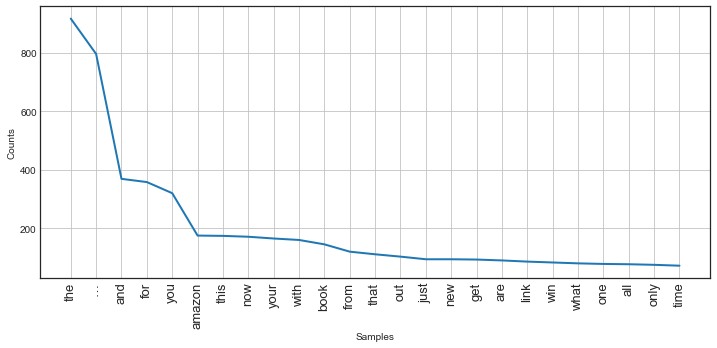

Text(0.5,0,'Word Rank')

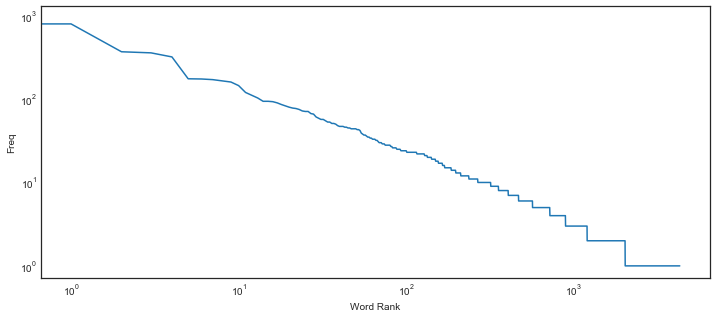

In [32]:
# most common words in twitter dataset
all_words = []
for line in list(df_twtr['message']):
    words = line.split()
    for word in words:
        all_words.append(word.lower())

# plot word frequency distribution of first few words
plt.figure(figsize=(12,5))
plt.xticks(fontsize=13, rotation=90)
fd = nltk.FreqDist(all_words)
fd.plot(25,cumulative=False)

# log-log of all words 
word_counts = sorted(Counter(all_words).values(), reverse=True)

plt.figure(figsize=(12,5))
plt.loglog(word_counts, linestyle='-', linewidth=1.5)
plt.ylabel("Freq")
plt.xlabel("Word Rank")

Pre-processing 2: Tokenize without out Stop-Words

- Our hypothetical training data has now been transformed into a much leaner body of text that is much cleaner for feature extraction. As we mentioned a few times before, we do have some words in the dataset that are common in natural human language but used in all sentiment expressions that we would be better off without them since they bring no useful features to our model.
- These words are commonly known as stop-words in NLP and the NLTK library comes with a dataset containing a long list of stop words that we are going to access and filter out of our dataset. Below is the actual words contained in the stop_words list. We can also make our own special case stop words to fit any unique case. For example if you are doing sentiment analysis on law documents, you would probably need a special set considering the jargon contained there in.

In [33]:
# show stop words examples
stop_words = stopwords.words('english') # Show some stop words
' , '.join(stop_words)[:200], len(stop_words)

("i , me , my , myself , we , our , ours , ourselves , you , you're , you've , you'll , you'd , your , yours , yourself , yourselves , he , him , his , himself , she , she's , her , hers , herself , it ",
 179)

Removing the stop words and other punctuations

In [34]:
# tokenize helper function
def text_process(raw_text):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in list(raw_text) if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return [word for word in nopunc.lower().split() if word.lower() not in stopwords.words('english')]


def remove_words(word_list):
    remove = ['...','“','”','’','…','amazon']
    return [w for w in word_list if w not in remove] #remove amazon since this is about amazon and the word has no signoficsnce for the sentiment

# -------------------------------------------

# tokenize message column and create a column for tokens

df_twtr['tokens'] = df_twtr['message'].apply(text_process) # tokenize style 1
df_twtr['tokens'] = df_twtr['tokens'].apply(remove_words) #tokenize style 2
df_twtr.head()

date            user_loc  followers  friends  \
0  2018-12-16 15:32:31  Ohio                70316      21765     
1  2018-12-16 15:32:24  Silicon Valley, CA  677        1577      
5  2018-12-16 15:32:01  Flint, Michigan     2258       4992      
7  2018-12-16 15:31:54  Indore, India       581        16        
9  2018-12-16 15:31:30  United States       11798      1874      

                                                                                          message  \
0  come over page there waiting for you…                                                            
1  had lot showrooming today people taking pictures books and buying them from the store and eve…   
5  check out today deals click here                                                                 
7  for sale domain …                                                                                
9  disney pixar cars travel time mack playset pixar                                                 

                                                                            tokens  
0  [come, page, waiting, you…]                                                      
1  [lot, showrooming, today, people, taking, pictures, books, buying, store, eve…]  
5  [check, today, deals, click]                                                     
7  [sale, domain]                                                                   
9  [disney, pixar, cars, travel, time, mack, playset, pixar]

In [35]:
df_twtr['tokens'].head()

0    [come, page, waiting, you…]                                                    
1    [lot, showrooming, today, people, taking, pictures, books, buying, store, eve…]
5    [check, today, deals, click]                                                   
7    [sale, domain]                                                                 
9    [disney, pixar, cars, travel, time, mack, playset, pixar]                      
Name: tokens, dtype: object

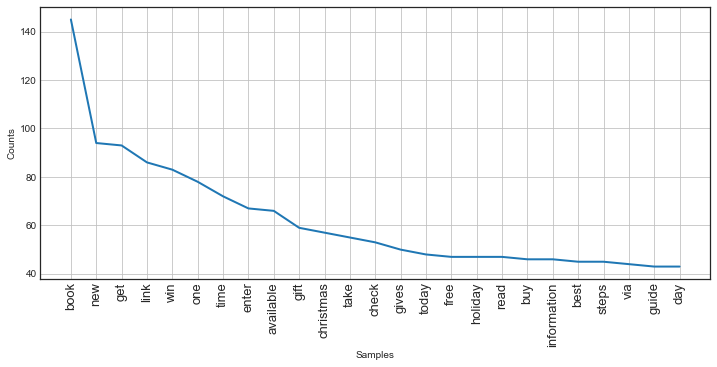

In [36]:
# most common words in twitter dataset
all_words = []
for ls in df_twtr['tokens']:
    words = [w for w in ls]
    for word in words:
        all_words.append(word.lower())
    
# plot word frequency distribution of first few words
plt.figure(figsize=(12,5))
plt.xticks(fontsize=13, rotation=90)
fd = nltk.FreqDist(all_words)
fd.plot(25,cumulative=False)

In [37]:
fd

FreqDist({'book': 145, 'new': 94, 'get': 93, 'link': 86, 'win': 83, 'one': 78, 'time': 72, 'enter': 67, 'available': 66, 'gift': 59, ...})

Word-Cloud

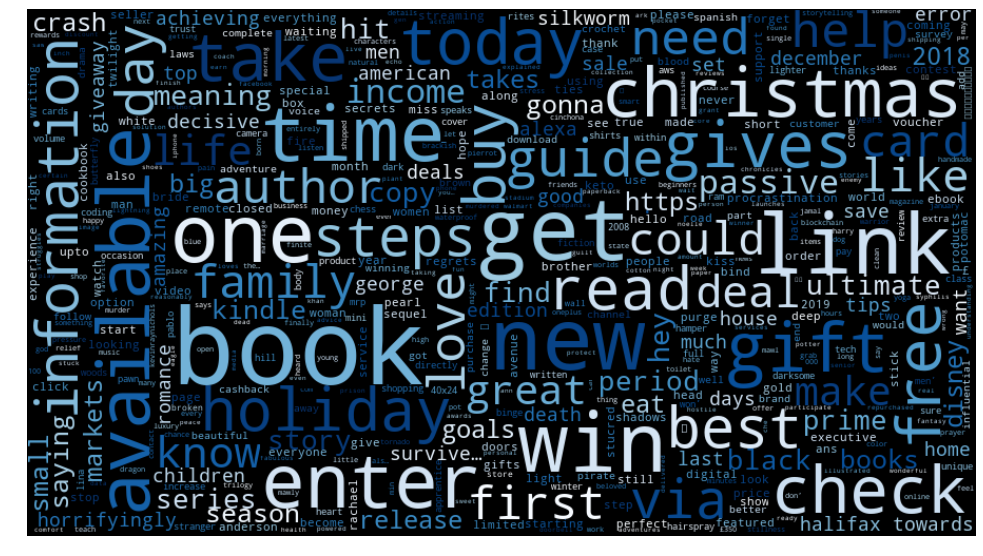

In [38]:
# draw a Word Cloud with word frequencies
wordcloud = WordCloud(width=900,
                      height=500,
                      max_words=500,
                      max_font_size=100,
                      relative_scaling=0.5,
                      colormap='Blues',
                      normalize_plurals=True).generate_from_frequencies(fd)

plt.figure(figsize=(17,14))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Pre-processing 3: Feature Extraction

- Vectorization - (Bag Of Words)

- We'll convert each message which is represented by a list of tokens into a vector that a machine learning model can understand.
- To do this we use the Bag Of Words model which is a three step process.
- Count how many times does a word occur in each message (Known as term frequency)
- Weigh the counts, so that frequent tokens get lower weight (inverse document frequency)
- Normalize the vectors to unit length, to abstract from the original text length (L2 norm)

- Each vector will have as many dimensions as there are unique words in the tweeter corpus.
- We will first use SciKit Learn's CountVectorizer funtion which converts a collection of text documents to a matrix of token counts.
- Imagine this as a 2-D matrix where 1-D is the entire vocabulary contained in the meassages and the other dimension is one column per tweet.
- Since there are so many messages, we can expect a lot of zero counts for the presence of every word in the data but SciKit Learn will output a Sparse Matrix.

In [39]:
# vetorize
bow_transformer = CountVectorizer(analyzer=text_process).fit(df_twtr['message'])
# print total number of vocab words
print(len(bow_transformer.vocabulary_))

4197


In [40]:
# example of vectorized text
sample_tweet = 'hello hello what is no good good bad super bad super'
print(sample_tweet)
print('\n')
# vector representation
bow_sample = bow_transformer.transform([sample_tweet])
print(bow_sample)
print('\n')

hello hello what is no good good bad super bad super


  (0, 392)	2
  (0, 1598)	2
  (0, 1717)	2
  (0, 3514)	2




In [41]:

# transform the entire DataFrame of messages
messages_bow = bow_transformer.transform(df_twtr['message'])

# check out the bag-of-words counts for the entire corpus as a large sparse matrix
print('Shape of Sparse Matrix: ', messages_bow.shape)
print('Amount of Non-Zero occurences: ', messages_bow.nnz)

Shape of Sparse Matrix:  (2324, 4197)
Amount of Non-Zero occurences:  13915


Term Frequency, Inverse Document Frequency

- TF-IDF stands for term frequency-inverse document frequency, and the tf-idf weight is a weight often used in information retrieval and text mining. This weight is a statistical measure used to evaluate how important a word is to a document in a collection or corpus.

- The importance increases proportionally to the number of times a word appears in the document but is offset by the frequency of the word in the corpus. Variations of the tf-idf weighting scheme are often used by search engines as a central tool in scoring and ranking a document's relevance given a user query.
- One of the simplest ranking functions is computed by summing the tf-idf for each query term; many more sophisticated ranking functions are variants of this simple model.
- Typically, the tf-idf weight is composed by two terms: the first computes the normalized Term Frequency (TF), aka. the number of times a word appears in a document, divided by the total number of words in that document; the second term is the Inverse Document Frequency (IDF), computed as the logarithm of the number of the documents in the corpus divided by the number of documents where the specific term appears.

- TF: Term Frequency, which measures how frequently a term occurs in a document. Since every document is different in length, it is possible that a term would appear much more times in long documents than shorter ones. Thus, the term frequency is often divided by the document length (aka. the total number of terms in the document) as a way of normalization:

- TF(t) = (Number of times term t appears in a document) / (Total number of terms in the document).
- IDF: Inverse Document Frequency, which measures how important a term is. While computing TF, all terms are considered equally important. However it is known that certain terms, such as "is", "of", and "that", may appear a lot of times but have little importance. Thus we need to weigh down the frequent terms while scale up the rare ones, by computing the following:
- IDF(t) = log_e(Total number of documents / Number of documents with term t in it).


- See below for a simple example.
  Example:

  Consider a document containing 100 words wherein the word cat appears 3 times.

  The term frequency (i.e., tf) for cat is then (3 / 100) = 0.03. Now, assume we have 10 million documents
  and the word cat appears in one thousand of these. Then, the inverse document frequency (i.e., idf) is 
  calculated as log(10,000,000 / 1,000) = 4. Thus, the Tf-idf weight is the product of these quantities:
  0.03 * 4 = 0.12.

In [42]:
# from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer().fit(messages_bow)
tfidf_sample = tfidf_transformer.transform(bow_sample)
print(tfidf_sample)

  (0, 3514)	0.5783926994971454
  (0, 1717)	0.4567536298737514
  (0, 1598)	0.42444800821668355
  (0, 392)	0.5260056036644922


In [43]:
messages_bow

<2324x4197 sparse matrix of type '<class 'numpy.int64'>'
	with 13915 stored elements in Compressed Sparse Row format>

In [44]:
# some IDF (inverse document frequency) example
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['hello']])
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['amazon']])

6.043425116919247
3.6516088901972585


In [45]:
# to transform the entire bag-of-words corpus
messages_tfidf = tfidf_transformer.transform(messages_bow)
print(messages_tfidf.shape)

(2324, 4197)


- After preprocessing the data, we are now ready to pass it through a ML classification algorithim. 
- That ends the text pre-processing stages of our workflow but we will revist this steps as one pipeline step in the section below.

# Modeling

Naive Bayes Classifier

- In this classification task we are going to use a Naive Bayes (NB) classifier which is based on the Bayes Theorem. In a nutshell, the NB classifier assumes that the presence of a particular feature in a class is unrelated to the presence of any other feature. So for example, a fruit may be considered to be an apple if it is red, round, and about 3″ in diameter. A Naive Bayes classifier considers each of these “features” (red, round, 3” in diameter) to contribute independently to the probability that the fruit is an apple, regardless of any correlations between features. Features, however, aren’t always independent which is often seen as a shortcoming of the Naive Bayes algorithm and this is why it’s labeled “naive”. However it is relatively simple to understand, build and train and mostly very fast all which makes it a good candidate for sentiment classification.

- Create Pipeline to manage the above preprocessing steps in one step
- SciKit Learn provides a pipeline capability that lets you define a pipeline workflow which will take all the above steps and even a classifier and grid search parameters. 
- Pipelines make code more readable and makes it easy to swap out pipeline pieces (which can include other ML algorithims and try different configurations
- Pipelines also allow for Cross Validation on to the model workflow.
- Pipelines also help avoid leaking statistics from your test data into the trained model in cross-validation, by ensuring that the same samples are used to train the transformers and predictors.

##### Cross Validation:

- The recommended method for training a good model is to first cross-validate using a portion of the training set itself to check if you have used a model with too much capacity (i.e. if the model is overfitting the data).
- To cross-validate and select the best parameter configuration at the same time, we use GridSearchCV. 
- This allows us to easily test out different hyperparameter configurations using for example the KFold strategy to split the model into random parts to find out if it's generalizing well or if it's overfitting.
- GridSearchCV allows you do define a ParameterGrid with hyperparameter configuration values to iterate over. All combinations are tested and scored and the best model returned.
- For our case, there are 4 + 2 + 2 parameter combinations to test and 10 kfold validations, so the model will be trained and tested on the validation set 8 x 10 = 80 times.

In [46]:
df_train

ItemID  Sentiment  \
0      1       0           
1      2       0           
2      3       1           
3      4       0           
4      5       0           
5      6       0           
6      7       1           
7      8       0           
8      9       1           
9      10      1           
10     11      0           
11     12      1           
12     13      0           
13     14      0           
14     15      0           
15     16      0           
16     17      0           
17     18      1           
18     19      0           
19     20      0           
20     21      0           
21     22      0           
22     23      1           
23     24      0           
24     25      0           
25     26      0           
26     27      0           
27     28      0           
28     29      1           
29     30      0           
...    ..     ..           
99959  99971   0           
99960  99972   1           
99961  99973   0           
99962  99974   0           
99963  99975   1           
99964  99976   1           
99965  99977   1           
99966  99978   0           
99967  99979   1           
99968  99980   1           
99969  99981   0           
99970  99982   0           
99971  99983   0           
99972  99984   1           
99973  99985   1           
99974  99986   0           
99975  99987   0           
99976  99988   1           
99977  99989   1           
99978  99990   1           
99979  99991   1           
99980  99992   1           
99981  99993   0           
99982  99994   1           
99983  99995   0           
99984  99996   0           
99985  99997   1           
99986  99998   0           
99987  99999   1           
99988  100000  1           

                                                                                                                                    SentimentText  \
0                           is so sad for my APL friend.............                                                                                
1                         I missed the New Moon trailer...                                                                                          
2                    omg its already 7:30 :O                                                                                                        
3                .. Omgaga. Im sooo  im gunna CRy. I've been at this dentist since 11.. I was suposed 2 just get a crown put on (30mins)...         
4               i think mi bf is cheating on me!!!       T_T                                                                                        
5               or i just worry too much?                                                                                                           
6             Juuuuuuuuuuuuuuuuussssst Chillin!!                                                                                                    
7             Sunny Again        Work Tomorrow  :-|       TV Tonight                                                                                
8            handed in my uniform today . i miss you already                                                                                        
9            hmmmm.... i wonder how she my number @-)                                                                                               
10           I must think about positive..                                                                                                          
11           thanks to all the haters up in my face all day! 112-102                                                                                
12           this weekend has sucked so far                                                                                                         
13          jb isnt showing in australia any more!                                                                                                  
14          ok thats it you win.   

In [53]:
# Run Train Data Through Pipeline analyzer=text_process
# uncomment below to train on a larger dataset but it is very slow for a regular laptop

# X_train, X_test, y_train, y_test = train_test_split(data['text'], data['label'], test_size=0.2)
X_train, X_test, y_train, y_test = train_test_split(df_train['SentimentText'][:5000], df_train['Sentiment'][:5000], test_size=0.2)


# create pipeline
pipeline = Pipeline([
    ('bow', CountVectorizer(strip_accents='ascii',
                            stop_words='english',
                            lowercase=True)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

# this is where we define the values for GridSearchCV to iterate over
parameters = {'bow__ngram_range': [(1, 1), (1, 2)],
              'tfidf__use_idf': (True, False),
              'classifier__alpha': (1e-2, 1e-3),
             }

# do 10-fold cross validation for each of the 6 possible combinations of the above params
grid = GridSearchCV(pipeline, cv=10, param_grid=parameters, verbose=1)
grid.fit(X_train,y_train)

# summarize results
print("\nBest Model: %f using %s" % (grid.best_score_, grid.best_params_))
print('\n')
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
params = grid.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("Mean: %f Stdev:(%f) with: %r" % (mean, stdev, param))

Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



Best Model: 0.764250 using {'bow__ngram_range': (1, 2), 'classifier__alpha': 0.01, 'tfidf__use_idf': False}


Mean: 0.747250 Stdev:(0.014484) with: {'bow__ngram_range': (1, 1), 'classifier__alpha': 0.01, 'tfidf__use_idf': True}
Mean: 0.758500 Stdev:(0.012095) with: {'bow__ngram_range': (1, 1), 'classifier__alpha': 0.01, 'tfidf__use_idf': False}
Mean: 0.744750 Stdev:(0.015474) with: {'bow__ngram_range': (1, 1), 'classifier__alpha': 0.001, 'tfidf__use_idf': True}
Mean: 0.751500 Stdev:(0.014107) with: {'bow__ngram_range': (1, 1), 'classifier__alpha': 0.001, 'tfidf__use_idf': False}
Mean: 0.756250 Stdev:(0.011883) with: {'bow__ngram_range': (1, 2), 'classifier__alpha': 0.01, 'tfidf__use_idf': True}
Mean: 0.764250 Stdev:(0.012813) with: {'bow__ngram_range': (1, 2), 'classifier__alpha': 0.01, 'tfidf__use_idf': False}
Mean: 0.754250 Stdev:(0.012786) with: {'bow__ngram_range': (1, 2), 'classifier__alpha': 0.001, 'tfidf__use_idf': True}
Mean: 0.757000 Stdev:(0.012252) with: {'bow__ngram_range'

[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:   13.0s finished


- We passed a combined 8 parameters to the GridsearchCV object and 10 folds for the cross validation which means that for every parameter combination, the grid will run 10 different iterations with a different test set every time.
- After trying out the different model parameter combinations, the GridsearchCV returns the best performing model which we can use to classify new (twitter) data. We save the model below to the working directory. This is also good for when we just want to retrieve the trained model in the future without retraining it and use it for classification of new text.
- Also a necessary step if you plan to deploy the model somewhere else like an app.

In [55]:
#Let us try different models
pipeline_ber = Pipeline([
    ('bow', CountVectorizer(strip_accents='ascii',
                            stop_words='english',
                            lowercase=True)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', BernoulliNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])




parameters = {'bow__ngram_range': [(1, 1), (1, 2)],
              'tfidf__use_idf': (True, False),
              'classifier__alpha': (1e-2, 1e-3),
             }

# do 10-fold cross validation for each of the 6 possible combinations of the above params
grid_1 = GridSearchCV(pipeline_1, cv=10, param_grid=parameters, verbose=1)
grid_1.fit(X_train,y_train)

# summarize results
print("\nBest Model: %f using %s" % (grid_1.best_score_, grid_1.best_params_))
print('\n')
means = grid_1.cv_results_['mean_test_score']
stds = grid_1.cv_results_['std_test_score']
params = grid_1.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("Mean: %f Stdev:(%f) with: %r" % (mean, stdev, param))

Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



Best Model: 0.749500 using {'bow__ngram_range': (1, 2), 'classifier__alpha': 0.01, 'tfidf__use_idf': True}


Mean: 0.747500 Stdev:(0.013021) with: {'bow__ngram_range': (1, 1), 'classifier__alpha': 0.01, 'tfidf__use_idf': True}
Mean: 0.747500 Stdev:(0.013021) with: {'bow__ngram_range': (1, 1), 'classifier__alpha': 0.01, 'tfidf__use_idf': False}
Mean: 0.745250 Stdev:(0.012712) with: {'bow__ngram_range': (1, 1), 'classifier__alpha': 0.001, 'tfidf__use_idf': True}
Mean: 0.745250 Stdev:(0.012712) with: {'bow__ngram_range': (1, 1), 'classifier__alpha': 0.001, 'tfidf__use_idf': False}
Mean: 0.749500 Stdev:(0.014721) with: {'bow__ngram_range': (1, 2), 'classifier__alpha': 0.01, 'tfidf__use_idf': True}
Mean: 0.749500 Stdev:(0.014721) with: {'bow__ngram_range': (1, 2), 'classifier__alpha': 0.01, 'tfidf__use_idf': False}
Mean: 0.747500 Stdev:(0.013466) with: {'bow__ngram_range': (1, 2), 'classifier__alpha': 0.001, 'tfidf__use_idf': True}
Mean: 0.747500 Stdev:(0.013466) with: {'bow__ngram_range':

[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:   12.8s finished


In [69]:
pipeline_trans = Pipeline([
    ('bow', CountVectorizer(strip_accents='ascii',
                            stop_words='english',
                            lowercase=True)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores 
])
    
X_train = pipeline_trans.fit_transform(X_train)


AttributeError: lower not found

In [93]:
from sklearn.naive_bayes import GaussianNB
gaus = GaussianNB()
from sklearn.model_selection import cross_val_score
gaus_scores = cross_val_score(gaus, X_train.toarray() ,y_train,scoring="accuracy", cv=10).mean()

In [95]:
from sklearn.naive_bayes import BernoulliNB
Bernoulli = BernoulliNB()
bern_scores = cross_val_score(Bernoulli, X_train.toarray() ,y_train,scoring="accuracy", cv=10).mean()

In [97]:
bern_scores

0.741755915661973

In [98]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression()
log_scores = cross_val_score(log_reg, X_train.toarray() ,y_train,scoring="accuracy", cv=10).mean()
print(log_scores)

C:\Users\amogh\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\amogh\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\amogh\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\amogh\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\amogh\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\amogh\Anaconda\lib\site-packages\sklearn\

0.7500040703379396


C:\Users\amogh\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



In [99]:
from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier()
sgd_scores = cross_val_score(sgd, X_train.toarray() ,y_train,scoring="accuracy", cv=10).mean()
print(sgd_scores)

C:\Users\amogh\Anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:144: FutureWarning:

max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.

C:\Users\amogh\Anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:144: FutureWarning:

max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.

C:\Users\amogh\Anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:144: FutureWarning:

max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not No

0.7447964831030195


In [100]:
from sklearn.svm import SVC
svc = SVC()
svc_scores = cross_val_score(svc, X_train.toarray() ,y_train,scoring="accuracy", cv=10).mean()
print(svc_scores)

C:\Users\amogh\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning:

The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.

C:\Users\amogh\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning:

The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.

C:\Users\amogh\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning:

The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.

C:\Users\amogh\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning:

The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled feat

KeyboardInterrupt: 

In [ ]:
# save best model to current working directory
joblib.dump(grid, "twitter_sentiment.pkl")

In [60]:

# load from file and predict using the best configs found in the CV step
model_NB = joblib.load("twitter_sentiment.pkl" )

# get predictions from best model above
y_preds = model_NB.predict(X_test)

print('accuracy score: ',accuracy_score(y_test, y_preds))
print('\n')
print('confusion matrix: \n',confusion_matrix(y_test,y_preds))
print('\n')
print(classification_report(y_test, y_preds))

accuracy score:  0.944


confusion matrix: 
 [[683  11]
 [ 45 261]]


              precision    recall  f1-score   support

           0       0.94      0.98      0.96       694
           1       0.96      0.85      0.90       306

   micro avg       0.94      0.94      0.94      1000
   macro avg       0.95      0.92      0.93      1000
weighted avg       0.94      0.94      0.94      1000



- In the cell above I used the best model to perform predictions to the unseen test data which lets us grade and retrieve the performance metrics.
- Among some of the performance metrics we can get back from above is the classification report and a confusion matrix.
- A Confusion Matrix (CM) is pretty straight forward but below is a key for interpreting it as well as the deriving a classification report: 


- From the confusion matrix:
- The model predicted 623 labels correctly as Negative and 125 labels correctly as Positive. 
- We also got 4 labels predicted as Positives even though they are Negatives (False Negatives).
Another thing we can tell from the CM is that the model predicted 62 labels as Negatives but they turned out to be Positives (False Positives).
From the classification report:
The classification report which can be obtained from the metrics in the confusion matrix, gives up more detailed information on model performance. 
Precision: 99% for label 0 and 93% for label 1. This number tells us what proportion of the labels were predicted correctly out of the total predictions for that class.
Recall: 90% for lable 0 and 100% for label 1. This is the number of correct predictions out of true labels for that class.
f1 -score: This is the weighted average of precision and recall for that class. It generally gives the bigger picture of how the model is performing for that label and obviously the higher this number is the better. 94 % for label 0 and 96% for label 1. 0 being negative sentiment and 1 being positive sentiment.

From the above metrics, the model seems to be performing relatively well even though it could do better on predicting the right labels for class 0. 
According to research human raters typically agree 80%[Roebuck, K. (2012-10-24)] of the time because of Inter-rater reliability issues. 
Therefore a 70% accurate program is doing almost as good as humans, even though such accuracy may not seem all that impressive. If a program were “right” 100% of the time, humans would still disagree with it about 20% of the time, since they disagree that much about any answer. 
We can also benchmark our model against similar work that performed an extensive study of sentiment analysis and binary classification of sentiment labels. The final model was based on Support Vector Machine(SVM) and went on to achieve an accuracy of 79.08%.
So far we have taken steps to avoid over fitting with the way we built our model pipeline but ultimately the true test is testing the model on unseen data. 
At the next step, I would like to run sentiment predictions with our model on the data we acquired through the twitter api and evaluate it's performance.

Run Prediction On Twitter Data and preview results


In [111]:

# run predictions on twitter data
tweet_preds = model_NB.predict(df_twtr['message'].dropna())

# append predictions to dataframe
df_tweet_preds = df_twtr.copy()
df_tweet_preds['predictions'] = tweet_preds
df_tweet_preds.shape

(2324, 7)

view some example preditions


In [112]:

# print text and sentiment

index = random.sample(range(tweet_preds.shape[0]), 20)
for text, sentiment in zip(df_tweet_preds.message[index],
                           df_tweet_preds.predictions[index]):
    print (sentiment, '--', text, '\n')

0.0 -- hey look another myth talking she explaining about how … 

0.0 -- step step guide plant propagation revised edition  

nan -- nan 

nan -- nan 

nan -- nan 

0.0 -- here the best battery case for your the best quality size and price https … 

nan -- nan 

nan -- nan 

0.0 -- understanding our struggles  

0.0 -- the house closed doors  

nan -- nan 

nan -- nan 

0.0 -- the house closed doors  

0.0 -- decorations gifts more upto off link  

nan -- nan 

0.0 -- ✨✨⚛⚛✨✨ retro 50s and print wall multiple sizes 10x10 13x13 15x15 gloss finish …  

0.0 -- nigeria  

nan -- nan 

nan -- nan 

1.0 -- the sequel  



C:\Users\amogh\Anaconda\lib\site-packages\pandas\core\series.py:842: FutureWarning:


Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike



In [113]:
df_twtr['message'].isna()

0       False
1       False
5       False
7       False
9       False
10      False
12      False
16      False
21      False
22      False
24      False
25      False
28      False
29      False
32      False
34      False
35      False
36      False
38      False
39      False
41      False
42      False
43      False
45      False
46      False
47      False
48      False
50      False
51      False
52      False
        ...  
6380    False
6382    False
6383    False
6388    False
6389    False
6390    False
6392    False
6394    False
6397    False
6398    False
6403    False
6405    False
6406    False
6412    False
6413    False
6414    False
6416    False
6419    False
6420    False
6421    False
6422    False
6423    False
6425    False
6426    False
6429    False
6431    False
6432    False
6435    False
6439    False
6441    False
Name: message, Length: 2324, dtype: bool

In [118]:
# Testing random text from the internet

# load model
model_NB = joblib.load("twitter_sentiment.pkl" )

# test string
sample_str = """ Thank you Amazon """


p = model_NB.predict([sample_str])

# formatting helper
def sentiment_str(x):
    if x==0:
        return 'Negative'
    else:
        return 'Positive'
#_____________________________________________

# test result ___ 0=Negative, 1=Positive
print("the sentence: \n\n'{}' \n\nhas a {} sentiment".format(sample_str,sentiment_str(p[0])))

the sentence: 

' Thank you Amazon ' 

has a Positive sentiment


# Geoplots, Final Thoughts and Conclusions

In this section we have also created geographic visualizations based from the downloaded tweets which is an important part of data storytelling.
While training any ML model is a big part the ML tasks, it is very important to be able to present our findings in ways that facilitate results understanding and decision making by the relevant parties.
We will load the dataframe containing predictions and explore country distributuion but also US states distribution and especially since the tweets revolve around US news.
It is worth mentioning that there are limitations with our dataset going forward. Majority of tweeter users do not broadcast their geo location but our search criteria only pulled tweets that had some information that would allow us to get this geolocation.
It is therefore possible that we are missing a lot of geo tags that would paint a different picture than we come up with when plotted on a map. Knowing this is crucial in interpreting results but also but also understanding how we can make the model more robust

In [67]:

# load dataframe with predictions
df_twtr


date                       user_loc  followers  friends  \
0     2018-12-16 15:32:31  Ohio                           70316      21765     
1     2018-12-16 15:32:24  Silicon Valley, CA             677        1577      
5     2018-12-16 15:32:01  Flint, Michigan                2258       4992      
7     2018-12-16 15:31:54  Indore, India                  581        16        
9     2018-12-16 15:31:30  United States                  11798      1874      
10    2018-12-16 15:31:26  Worldwide                      51768      48021     
12    2018-12-16 15:31:20  Here There and Everywhere      5757       4410      
16    2018-12-16 15:30:57  United States                  92         784       
21    2018-12-16 15:30:27  Everyone has to be somewhere   15262      13997     
22    2018-12-16 15:30:26  Jamaica Plain, Massachussets   34         608       
24    2018-12-16 15:30:19  Worldwide                      51768      48021     
25    2018-12-16 15:30:18  Illinois, USA                  85         119       
28    2018-12-16 15:30:15  Gibraltar                      35         117       
29    2018-12-16 15:30:10  Florida, USA                   7337       6779      
32    2018-12-16 15:30:04  Platform 9 3/4                 1418       1057      
34    2018-12-16 15:30:02  New York City                  5693       3211      
35    2018-12-16 15:30:00  Montreal, Canada               2339       2483      
36    2018-12-16 15:29:53  United States                  862        1417      
38    2018-12-16 15:29:43  Greater Toronto                12699      11736     
39    2018-12-16 15:29:34  Bakersfield, CA                163        77        
41    2018-12-16 15:29:29  Worldwide                      51768      48021     
42    2018-12-16 15:29:22  Kolkata, India                 1384       1179      
43    2018-12-16 15:29:10  United States                  1778       3225      
45    2018-12-16 15:29:01  Haunting of Hill House         8          175       
46    2018-12-16 15:29:00  Lafayette, IN                  130        1816      
47    2018-12-16 15:28:56  Seattle-ish                    862        706       
48    2018-12-16 15:28:55  In DC's world                  1957       2965      
50    2018-12-16 15:28:33  Ontario, Canada                3530       3477      
51    2018-12-16 15:28:25  United States                  92         784       
52    2018-12-16 15:28:20  Jamaica Plain, Massachussets   34         608       
...                   ...                           ...   ..         ...       
6380  2018-12-16 03:21:17  India                          11971      6         
6382  2018-12-16 03:20:59  Texas                          312        269       
6383  2018-12-16 03:20:57  United States                  3328       3328      
6388  2018-12-16 03:20:01  Worldwide                      208217     144616    
6389  2018-12-16 03:20:01  Worldwide                      122229     110501    
6390  2018-12-16 03:19:59  India                          11971      6         
6392  2018-12-16 03:19:50  New Mexico                     2329       2253      
6394  2018-12-16 03:19:47  Semona                         261        104       
6397  2018-12-16 03:19:40  دبي, الامارات العربية المتحدة  3493       155       
6398  2018-12-16 03:19:36  New York, USA                  1364       1879      
6403  2018-12-16 03:19:01  Wisconsin, USA                 6533       50        
6405  2018-12-16 03:17:40  Arkansas, USA                  296        472       
6406  2018-12-16 03:17:38  North Branch, MI               2767       3025      
6412  2018-12-16 03:16:31  Toronto, Hamilton, KW Ontario  21754      19270     
6413  2018-12-16 03:16:19  Global                         25511      7938      
6414  2018-12-16 03:15:47  Seattle                        220        251       
6416  2018-12-16 03:15:23  La-weezy-anners                130        334       
6419  2018-12-16 03:15:04  Darbhanga                      3          32        
6420  2018-12-16 03:1